# $lambda=0.01$

# Import dependencies

In [1]:
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from PIL import Image
import warnings
import os
import random
import datetime

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

2021-11-20 08:51:17.493654: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))

TensorFlow 2.4.1; Keras 2.4.0


In [3]:
tf.test.gpu_device_name()


2021-11-20 08:51:18.906695: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-20 08:51:18.908646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-20 08:51:18.945875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 08:51:18.946324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 32

'/device:GPU:0'

# Define Parameters

In [4]:
BASE_PATH = "src_to_tar/"
TAR_BASE_PATH = "./categorical-east/"
NUM_CLASSES = 4
im_height, im_width = 256, 256
test_ratio = 0.1
BATCH_SIZE = 8
NUM_EPOCHS = 50

# Read Dataset

In [5]:
# Extrac name of files
files = os.listdir(BASE_PATH)
tar_files = os.listdir(TAR_BASE_PATH)
files = [BASE_PATH + f for f in files]
# files = files[:800]
tar_files = [TAR_BASE_PATH + f for f in tar_files]
print("###SRC FILES###")
print(BASE_PATH)
print(len(files))
print("###TAR FILES###")
print(TAR_BASE_PATH)
print(len(tar_files))

###SRC FILES###
src_to_tar/
1188
###TAR FILES###
./categorical-east/
425


In [6]:
random.seed(10)
random.shuffle(files)
random.shuffle(tar_files)
test_size = int(len(files) * test_ratio)

test_files = files[:test_size]
non_test_files = files[test_size:]

val_size = int(len(non_test_files) * test_ratio)
val_files = non_test_files[:val_size]
train_files = non_test_files[val_size:]

print("Train size:", len(train_files))
print("Validation size:", len(val_files))
print("Test size:", len(test_files))
print(train_files[0])


Train size: 963
Validation size: 107
Test size: 118
src_to_tar/133.npy


# Data Generator

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generate data for keras'
    def __init__(self, image_paths, batch_size, augment, shuffle, normalize=False, gan=False,
                minimum=0, maximum=0):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.normalize = normalize
        self.minimum = minimum
        self.maximum = maximum
        self.gan = gan
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))
  

    def on_epoch_end(self):
        'Updates indices after each epoch'
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
              np.random.shuffle(self.indices)
  
    def __getitem__(self, index):
        'Generate one batch of data'
        # select indices of data for next batch
        indices = self.indices[index*self.batch_size: (index+1)*self.batch_size]

        # select data and load images
        imgs_lbls = []
        for i in indices:
            img_lbl = np.load(self.image_paths[i])
            # img_lbl = np.moveaxis(img_lbl, 0, -1)
            imgs_lbls.append(img_lbl)

        # preprocess and augment data
        if self.augment:
            img_lbls = self.augmentor(imgs_lbls)
    
        images = []
        labels = []
        for img_lbl in imgs_lbls:
            if self.gan:
                image = img_lbl[..., :12]
                images.append(image)
                label = img_lbl[..., 12:]
                labels.append(label)
            else:
                image = img_lbl[:12, :, :]
                image = np.moveaxis(image, 0, -1)
                images.append(image)
                label = img_lbl[12:, :, :]
                label = np.moveaxis(label, 0, -1)
                labels.append(label)
        images = np.array(images, dtype=np.float32)
        if self.normalize:
            images = (images - self.minimum) / (self.maximum - self.minimum)
        elif self.gan:
            images = (images + 1) / 2
        return images, np.array(labels, dtype=np.float32)
  
    def augmentor(self, imgs_lbls):
        k = np.random.randint(0, 4)
        imgs_lbls = [np.rot90(img_lbl, axes=(0, 1), k=k) for img_lbl in imgs_lbls]

        if np.random.randint(0, 2) == 0:
            imgs_lbls = [np.fliplr(img_lbl) for img_lbl in imgs_lbls]
        if np.random.randint(0, 2) == 0:
            imgs_lbls = [np.flipud(img_lbl) for img_lbl in imgs_lbls]
    

        return imgs_lbls

# importing models from keras_unet_collection

In [8]:
from keras_unet_collection.keras_unet_collection import models

In [22]:
d_model, model = models.unet_2d((256, 256, 12), [16, 32, 32, 64], n_labels=NUM_CLASSES,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet',
                      is_domain_adaptation=False, da_type='conv2d', da_kernels=[32, 16])

In [23]:
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 12 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 256, 256, 16) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 256, 256, 16) 64          unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (GELU)  (None, 256, 256, 16) 0           unet_down0_0_bn[0][0]            
_________________________________________________________________________________________

In [24]:
maximum, minimum = 14.733826, -49.208305

train_gen = DataGenerator(image_paths=train_files, batch_size=BATCH_SIZE,  augment=True, 
                          shuffle=True, normalize=False, gan=True, maximum=maximum, minimum=minimum)
val_gen = DataGenerator(image_paths=val_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                        normalize=False, gan=True, maximum=maximum, minimum=minimum)
test_gen = DataGenerator(image_paths=test_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                         normalize=False, gan=True, maximum=maximum, minimum=minimum)

tar_gen = DataGenerator(image_paths=tar_files, batch_size=BATCH_SIZE, augment=False, shuffle=False,
                         normalize=True, maximum=maximum, minimum=minimum)



In [25]:
x, y = train_gen[10]
xx, yy = tar_gen[0]
x.shape, y.shape, xx.shape, yy.shape, x.min(), x.max()

((8, 256, 256, 12),
 (8, 256, 256, 4),
 (8, 256, 256, 12),
 (8, 256, 256, 4),
 0.00032889843,
 0.95284176)

In [26]:
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in np.arange(len(weightsList), dtype='int64')]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [27]:
other = 17749814 + 17766350 + 22149798
corn = 204516 + 172453 + 235173
cotton = 88734 + 26780 + 1677
rice = 10122026 + 6884977 + 7128782
total = other + corn + cotton + rice 

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_other = (1 / other) * (total / 2.0)
weight_for_corn = (1 / corn) * (total / 2.0)
weight_for_cotton = (1 / cotton) * (total / 2.0)
weight_for_rice = (1 / rice) * (total / 2.0)

class_weight = {0: weight_for_other, 1: weight_for_corn, 2: weight_for_cotton, 3: weight_for_rice}

print('Weight for class 0: {:.2f}'.format(weight_for_other))
print('Weight for class 1: {:.2f}'.format(weight_for_corn))
print('Weight for class 2: {:.2f}'.format(weight_for_cotton))
print('Weight for class 3: {:.2f}'.format(weight_for_rice))

weights = [weight_for_other, weight_for_corn, weight_for_cotton, weight_for_rice]

Weight for class 0: 0.72
Weight for class 1: 67.41
Weight for class 2: 352.12
Weight for class 3: 1.71


In [28]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-8,
    decay_steps=2000,
    decay_rate=0.9)
optimizer1 = keras.optimizers.Adam(learning_rate=lr_schedule)

In [29]:
model.compile(optimizer=optimizer1, 
              loss=weightedLoss(keras.losses.categorical_crossentropy, weights),
              metrics=['accuracy'])

In [30]:
checkpoint_filepath = 'CycUnetCheckpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [31]:
model.load_weights('UnetCheckpoint/checkpoint')

In [32]:
# contract = keras.Sequential(layers[:18])
# contract.trainable = False
# x = contract(inputs, training=False)

# for i in range(18, len(layers)):
#     x = layers[i](x)

# model = keras.Model(inputs, x)
# model.summary()

In [33]:
model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[model_checkpoint_callback])

2021-11-20 08:52:22.926955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-20 08:52:22.945896: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-11-20 08:52:24.831238: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-20 08:52:25.741128: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-20 08:52:25.800163: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-11-20 08:52:26.449780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


120/120 [==============================] - 39s 112ms/step - loss: 4.4564 - accuracy: 0.7961 - val_loss: 2.4499 - val_accuracy: 0.8084
Epoch 2/20
120/120 [==============================] - 13s 105ms/step - loss: 4.5075 - accuracy: 0.7881 - val_loss: 2.3675 - val_accuracy: 0.8118
Epoch 3/20
120/120 [==============================] - 13s 106ms/step - loss: 4.7828 - accuracy: 0.7909 - val_loss: 2.3570 - val_accuracy: 0.8126
Epoch 4/20
120/120 [==============================] - 12s 104ms/step - loss: 3.9236 - accuracy: 0.7921 - val_loss: 2.3596 - val_accuracy: 0.8122
Epoch 5/20
120/120 [==============================] - 12s 103ms/step - loss: 4.2645 - accuracy: 0.7896 - val_loss: 2.3533 - val_accuracy: 0.8117
Epoch 6/20
120/120 [==============================] - 12s 104ms/step - loss: 5.2605 - accuracy: 0.7895 - val_loss: 2.3676 - val_accuracy: 0.8122
Epoch 7/20
120/120 [==============================] - 12s 104ms/step - loss: 4.1404 - accuracy: 0.7951 - val_loss: 2.3525 - val_accuracy: 0.8

In [37]:
x.shape

(8, 256, 256, 12)

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [35]:
def plot_confusion_matrix(gen):
    preds = []
    trains = []
    for i, (image, label) in enumerate(gen):
        pred = model.predict(image)
        pred = np.argmax(pred, axis=-1)
        # pred = np.where(pred > 0.5, 1, 0)
        pred = pred.flatten()
        preds.append(pred)
        label = np.argmax(label, axis=-1)
        label = label.flatten()
        trains.append(label)

    trains = np.concatenate(trains)
    preds = np.concatenate(preds) 

    lin_preds = preds.flatten()

    lin_trains = trains.flatten()
    cm = confusion_matrix(lin_trains, lin_preds, normalize='true')
    cm_display = ConfusionMatrixDisplay(cm, display_labels=['others', 'Corn', 'Cotton', 'rice']).plot(cmap=plt.cm.Blues)
    plt.show()

In [36]:
model.load_weights(checkpoint_filepath)

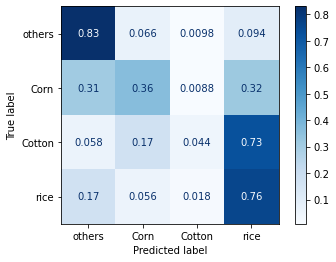

In [37]:
plot_confusion_matrix(train_gen)

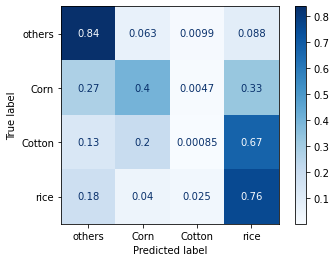

In [38]:
plot_confusion_matrix(val_gen)

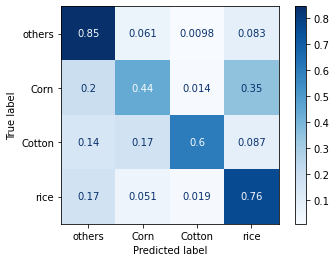

In [39]:
plot_confusion_matrix(test_gen)

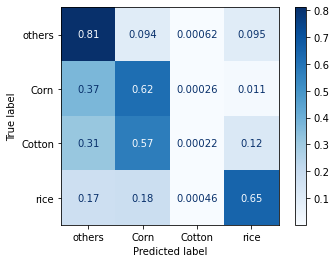

In [40]:
plot_confusion_matrix(tar_gen)

In [41]:
def plot_cnf_matrix(gen):
    # preds = np.zeros((len(gen), 65536, 1))
    # trains = np.zeros((len(gen), 65536, 1))
    preds = []
    trains = []
    for i, (image, label) in enumerate(gen):
        pred = model.predict(image)
        pred = np.argmax(pred, axis=-1)
        # pred = np.where(pred > 0.5, 1, 0)
        pred = pred.flatten()
        preds.append(pred)
        label = np.argmax(label, axis=-1)
        label = label.flatten()
        trains.append(label)

    trains = np.concatenate(trains)
    preds = np.concatenate(preds) 

    lin_preds = preds.flatten()

    lin_trains = trains.flatten()
    
    cm = tf.math.confusion_matrix(lin_trains, lin_preds)
#     cms = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
    
    # Get confusion matrix
#     cm = tf.confusion_matrix(tf.reshape(y_true, [-1]),
#                              tf.reshape(y_pred, [-1]))
    
    # Get precisions
    TP = tf.linalg.diag_part(cm)
    precisions = TP / tf.reduce_sum(cm, axis=0)
    
    # Get recalls
    TP = tf.linalg.diag_part(cm)
    recalls = TP / tf.reduce_sum(cm, axis=1)
    
    # Get F1s
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    
    sns.heatmap(
        cm, annot=True,
        xticklabels=[0, 1],
        yticklabels=[0, 1])
    plt.xlabel("True")
    plt.ylabel("Predicted")
    
    plt.show()
    
#     return np.mean(f1s[1:])
    m = tf.keras.metrics.MeanIoU(num_classes=4)
    m.update_state(lin_trains, lin_preds)
    print(m.result().numpy())
    print(np.mean(f1s))

2021-11-20 08:58:32.551961: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1006632960 exceeds 10% of free system memory.


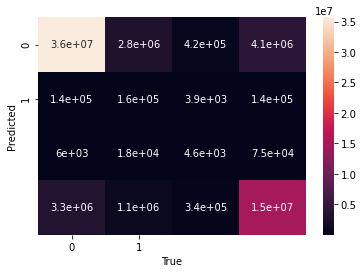

0.35739335
0.4287445428074623


In [42]:
plot_cnf_matrix(train_gen)

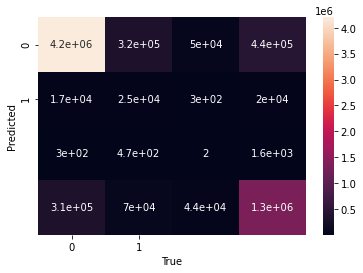

0.3598709
0.43337156602497506


In [43]:
plot_cnf_matrix(val_gen)

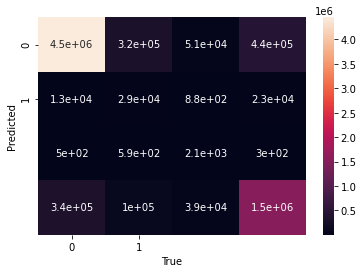

0.37255433
0.45024943691414826


In [44]:
plot_cnf_matrix(test_gen)

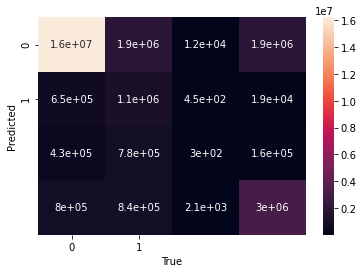

0.34884438
0.453017485241791


In [45]:
plot_cnf_matrix(tar_gen)

In [46]:
model.layers[27].name

'unet_down3_conv_1_activation'

In [47]:
from tensorflow.keras.models import Model

In [48]:
maximum, minimum = 14.733826, -49.208305

test_gen = DataGenerator(image_paths=test_files, batch_size=100, augment=False, shuffle=False,
                         normalize=False, gan=True, maximum=maximum, minimum=minimum)

tar_gen = DataGenerator(image_paths=tar_files, batch_size=100, augment=False, shuffle=False,
                         normalize=True, maximum=maximum, minimum=minimum)



In [49]:
# Testing
mid_model = Model(inputs=[model.input], outputs=[model.layers[27].output])

In [50]:
x_test, _ = test_gen[0]
x_tar, _ = tar_gen[0]
print(x_test.shape, x_tar.shape)
x = np.vstack((x_test, x_tar))
print(x.shape)

(100, 256, 256, 12) (100, 256, 256, 12)
(200, 256, 256, 12)


In [51]:
features = mid_model.predict(x)
print(features.shape)

(200, 32, 32, 64)


In [52]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [53]:
features = features.reshape(x.shape[0], -1)
features.shape

(200, 65536)

In [54]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(features)

In [55]:
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)

/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/qc/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 38.635114
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.699280
[t-SNE] KL divergence after 1000 iterations: 0.571087


In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
color_map = np.concatenate((np.ones(features.shape[0]//2), np.zeros(features.shape[0]//2)))
color_map.shape

(200,)

In [58]:
tsne_results.shape

(200, 2)

<AxesSubplot:>

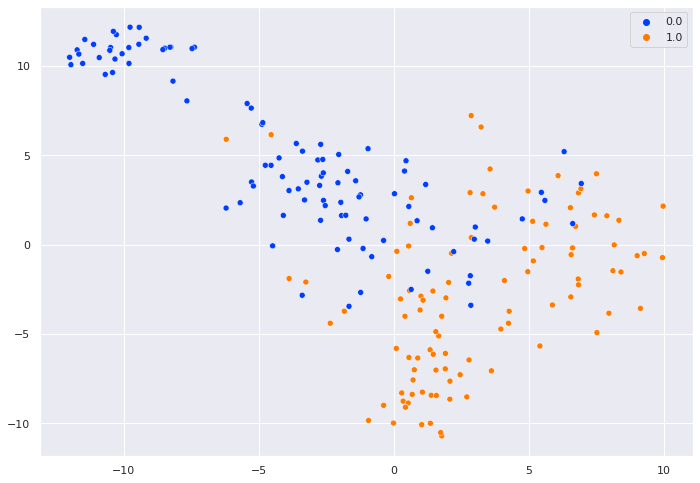

In [62]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=color_map, legend='full', palette=palette)